In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from prophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')

In [2]:
%%R
library(prophet)
df <- read.csv('../examples/example_wp_log_peyton_manning.csv')
m <- prophet(df)
future <- make_future_dataframe(m, periods=366)
m <- prophet(df)
forecast <- predict(m, future)

R[write to console]: Loading required package: Rcpp

R[write to console]: Loading required package: rlang

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



You may have noticed in the earlier examples in this documentation that real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

### Automatic changepoint detection in Prophet
Prophet detects changepoints by first specifying a large number of *potential changepoints* at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of *possible* places where the rate can change, but will use as few of them as possible. Consider the Peyton Manning forecast from the Quickstart. By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. The vertical lines in this figure indicate where the potential changepoints were placed:

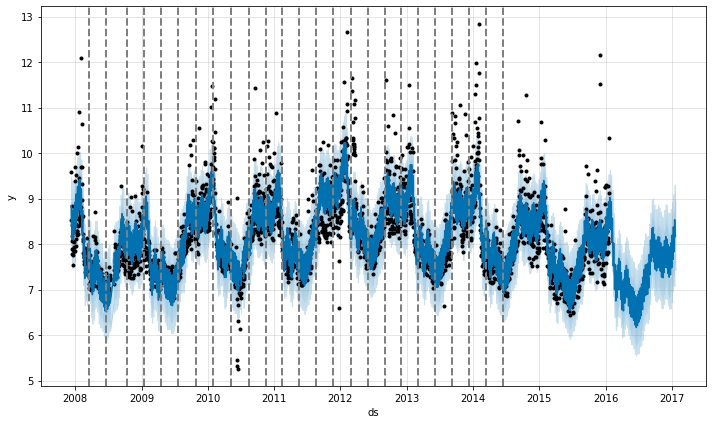

In [2]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)
fig = m.plot(forecast)
for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)

Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused. We can see this by plotting the magnitude of the rate change at each changepoint:

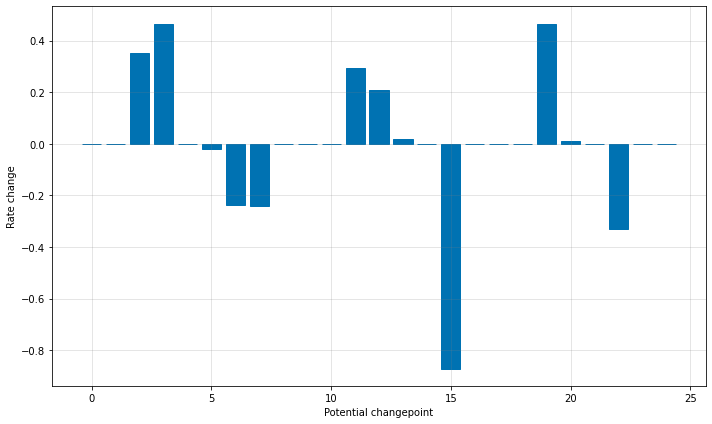

In [3]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

The number of potential changepoints can be set using the argument `n_changepoints`, but this is better tuned by adjusting the regularization. The locations of the signification changepoints can be visualized with:

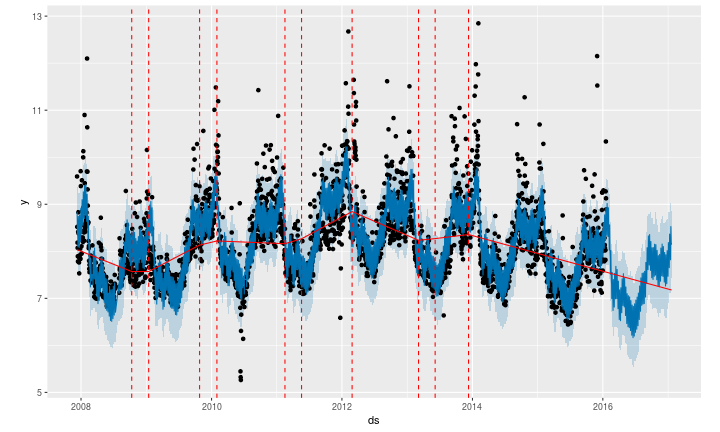

In [3]:
%%R -w 10 -h 6 -u in
plot(m, forecast) + add_changepoints_to_plot(m)

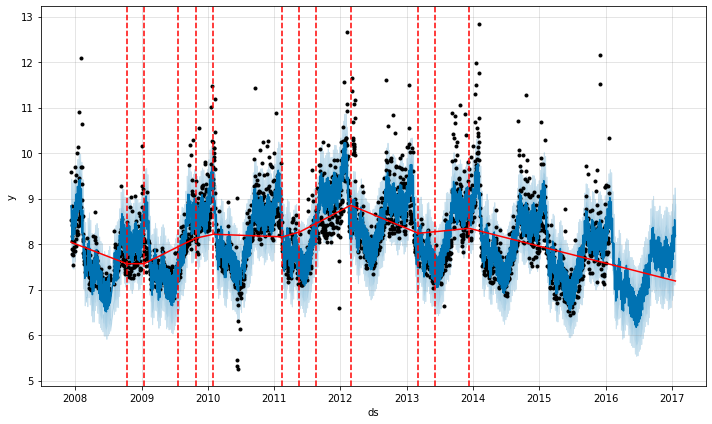

In [4]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using the `changepoint_range` argument. For example, `m = Prophet(changepoint_range=0.9)` in Python or `m <- prophet(changepoint.range = 0.9)` in R will place potential changepoints in the first 90% of the time series.

### Adjusting trend flexibility
If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument `changepoint_prior_scale`. By default, this parameter is set to 0.05. Increasing it will make the trend *more* flexible:

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



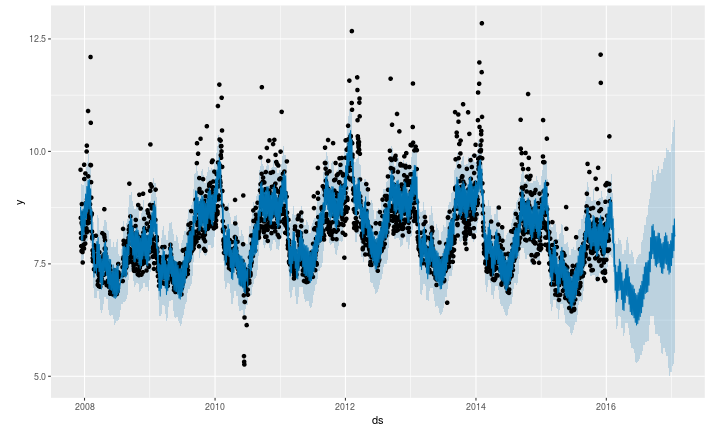

In [4]:
%%R -w 10 -h 6 -u in
m <- prophet(df, changepoint.prior.scale = 0.5)
forecast <- predict(m, future)
plot(m, forecast)

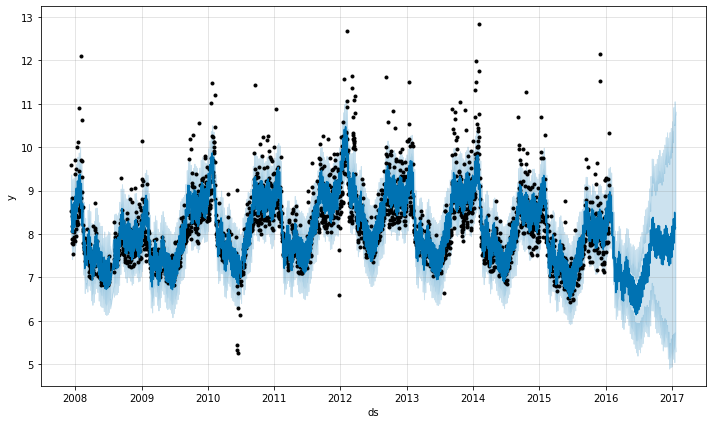

In [5]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

Decreasing it will make the trend *less* flexible:

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



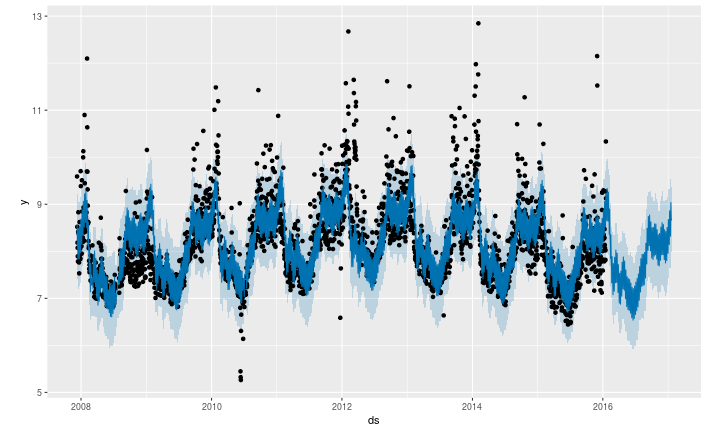

In [5]:
%%R -w 10 -h 6 -u in
m <- prophet(df, changepoint.prior.scale = 0.001)
forecast <- predict(m, future)
plot(m, forecast)

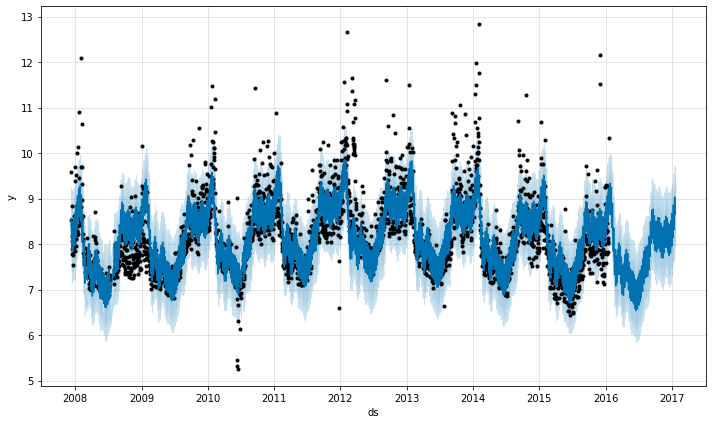

In [6]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

When visualizing the forecast, this parameter can be adjusted as needed if the trend seems to be over- or under-fit. In the fully-automated setting, see the documentation on cross validation for recommendations on how this parameter can be tuned.

### Specifying the locations of the changepoints

If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the `changepoints` argument. Slope changes will then be allowed only at these points, with the same sparse regularization as before. One could, for instance, create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes. As another example, the changepoints could be entirely limited to a small set of dates, as is done here:

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



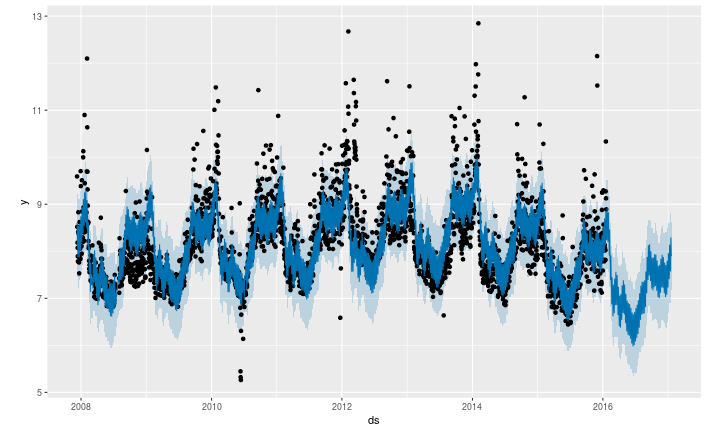

In [6]:
%%R -w 10 -h 6 -u in
m <- prophet(df, changepoints = c('2014-01-01'))
forecast <- predict(m, future)
plot(m, forecast)

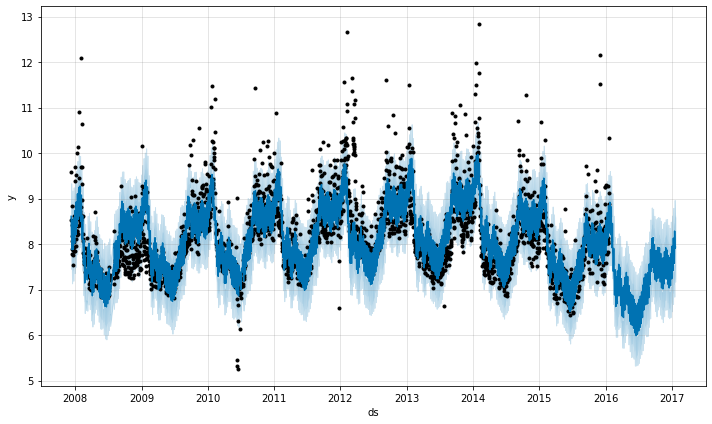

In [7]:
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)